In [3]:
# dont forget to switch to GPU if possible
google_colab_env = False
save_logs_and_models = False

In [4]:
if google_colab_env:
    from google.colab import drive
    %tensorflow_version 1.x
    drive.mount('/content/drive')
    !git clone https://github.com/GrzegorzKazana/artificial-music.git

## importing dataset, splitting tracks

In [5]:
import os
import sys
import json
import numpy as np
from scipy import sparse

proj_base_path = ('/content/artificial-music' 
                  if google_colab_env else '../../../')

data_base_path =  ('/content/drive/My Drive/artificial-music/datasets'
                   if google_colab_env else '../../../datasets')

models_base_path =  ('/content/drive/My Drive/artificial-music/pretrained_models' 
                     if google_colab_env else '../../../pretrained_models')

sys.path.append(os.path.join(os.getcwd(), proj_base_path))

dataset_path = 'numpy/pokemon_clustered_time_no_transp'
word_vectors_file = 'meta/_word_vectors_5000_ignore_ratio=0.0_no_shortest.wv'
duration_dict_file = 'meta/durations_dict.json'

In [6]:
word_vectors_path = os.path.join(data_base_path, dataset_path, word_vectors_file)
with open(os.path.join(data_base_path, dataset_path, duration_dict_file)) as fp:
    duration_dict = json.load(fp)

tracks_path = os.path.join(data_base_path, dataset_path)
track_paths = [os.path.join(tracks_path, f) for f in os.listdir(tracks_path) if f.endswith('.npz')]

tracks = [sparse.load_npz(p).toarray() for p in track_paths]

for t in tracks: print(t.shape, end='')

(917, 152)(487, 152)(551, 152)(228, 152)(343, 152)(1002, 152)(317, 152)(253, 152)(121, 152)(389, 152)

In [7]:
# dropping ~0 duration class datapoints
tracks = [t[t[:, 128] != 1] for t in tracks]
tracks = [t for t in tracks if t.shape[0]]

### prepare dataset generator

In [8]:
def dataset_gen(tracks, window_size_range=(20, 300), batch_size=16):
    """
    tracks - list of np.arrays of shape (track_length, frame_size)
    window_size - length of generated batch
    batch_size - number of sequences in batch
    """
    max_window_size = min([len(t) for t in tracks]) - 3
    while True:
        window_size = np.random.randint(window_size_range[0], min(max_window_size, window_size_range[1]))
        # select #batch_size tracks
        selected_track_indicies = [np.random.randint(0, len(tracks)) for _ in range(batch_size)]
        # select sequence starting point for each track
        sequence_indicies = [np.random.randint(0, len(tracks[sti]) - window_size - 2)
                             for sti in selected_track_indicies]
        
        
        # create slices for x and y
        x_slice = lambda seqi: np.s_[seqi:seqi + window_size]
        y_slice = lambda seqi: np.s_[seqi + 1:seqi + window_size + 1]
        
        x = [tracks[sti][x_slice(seqi)] for sti, seqi in zip(selected_track_indicies, sequence_indicies)]
        y = [tracks[sti][y_slice(seqi)] for sti, seqi in zip(selected_track_indicies, sequence_indicies)]

        yield np.stack(x), np.stack(y)
        
x, y = next(dataset_gen(tracks, (10, 50), 5))
x.shape, y.shape

((5, 45, 152), (5, 45, 152))

## Setting up model

In [9]:
from tensorflow import keras as K

NOTES_INPUT_SIZE = 128
DURATION_INPUT_SIZE = 24

MAIN_LSTM_SIZE = 256
MAIN_DENSE_SIZE = 128

NOTES_LSTM_SIZE = 128
DURATION_LSTM_SIZE = 32

NOTES_OUTPUT_DENSE = 128
DURATION_OUTPUT_DENSE = 32

NOTES_OUTPUT_SIZE = NOTES_INPUT_SIZE
DURATION_OUTPUT_SIZE = DURATION_INPUT_SIZE

BATCH_SIZE = 4
WINDOW_SIZE_RANGE = (10, 25)

NOTES_INPUT_SHAPE = (None, NOTES_INPUT_SIZE)
DURATION_INPUT_SHAPE = (None, DURATION_INPUT_SIZE)
# None allows for variable seq_length between batches

NOTES_INPUT_NAME = 'notes_input'
DURATION_INPUT_NAME = 'duration_input'
NOTES_OUTPUT_NAME = 'notes_output'
DURATION_OUTPUT_NAME = 'duration_output'

#### load existing model

In [ ]:
# or load saved model
model_path = 'lstm_lstm/embedded_16_128_stacked_32/embedded_16_128_stacked_32md_e200_t2019-10-09T09_59_31_cpu.h5'
model = K.models.load_model(os.path.join(models_base_path, model_path))

#### or create new one

In [10]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, CuDNNLSTM, Input, Concatenate
rnn_layer = CuDNNLSTM if google_colab_env else LSTM

x1 = Input(NOTES_INPUT_SHAPE, name=NOTES_INPUT_NAME)
x2 = Input(DURATION_INPUT_SHAPE, name=DURATION_INPUT_NAME)

h1 = Concatenate()([x1, x2])
h2 = rnn_layer(MAIN_LSTM_SIZE, return_sequences=True)(h1)
h3 = Dense(MAIN_DENSE_SIZE)(h2)

g1 = rnn_layer(NOTES_LSTM_SIZE, return_sequences=True)(h3)
g2 = Dense(NOTES_OUTPUT_DENSE)(g1)
y1 = Dense(NOTES_OUTPUT_SIZE, name=NOTES_OUTPUT_NAME, activation='sigmoid')(g2)

i1 = rnn_layer(DURATION_LSTM_SIZE, return_sequences=True)(h3)
i2 = Dense(DURATION_OUTPUT_DENSE)(i1)
y2 = Dense(DURATION_OUTPUT_SIZE, name=DURATION_OUTPUT_NAME, activation='softmax')(i2)

model = Model(inputs=[x1, x2], outputs=[y1, y2])

model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
notes_input (InputLayer)        [(None, None, 128)]  0                                            
__________________________________________________________________________________________________
duration_input (InputLayer)     [(None, None, 24)]   0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, None, 152)    0           notes_input[0][0]                
                                                                 duration_input[0][0]             
__________________________________________________________________________________________________
lstm (LSTM)  

In [11]:
losses = {
    NOTES_OUTPUT_NAME: 'binary_crossentropy',
    DURATION_OUTPUT_NAME: 'categorical_crossentropy',
}

metrics = {
    NOTES_OUTPUT_NAME: ['binary_crossentropy'],
    DURATION_OUTPUT_NAME: ['categorical_accuracy'],
}

# maybe diffrent weights for outputs???

model.compile(
    loss=losses,
    optimizer='adam', 
    metrics=metrics,
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


#### define training callbacks

In [20]:
from src.training.common.training_callbacks import ModelAndLogSavingCallback, GeneratingAndPlottingCallback, GeneratingOnSameSeedCallback

logging_path = 'lstm_clustered_time'
experiment_name = f'embedded_clustered_time_{MAIN_LSTM_SIZE}_no_shortest'
experiment_path = os.path.join(models_base_path, logging_path, experiment_name)
os.makedirs(experiment_path, exist_ok=True)

if save_logs_and_models:
    # logging callback
    print(f'saving checkpoints and logs to {experiment_path}')
    log_callback = ModelAndLogSavingCallback(model, experiment_path, save_log_only=True)

# generating callback
from src.generating.generating import recurrent_generate
from src.generating.sparse_clustered_time_generating_seeds import get_seed_generators
from src.data_processing.common.helpers import pipe
from src.data_processing.sparse_notes_classified_time.np2mid import np2sparse
from src.data_processing.sparse_notes_classified_time.embed_adapt import decode_note_vector_track

SEED_LENGTH = 5
GENERATED_SEQ_LENGTH = 150
GENERATING_WINDOW_SIZE = 15

sd = get_seed_generators(duration_dict, ignore_shortest=True)

def seed_generator():
    return np.concatenate([
        *[sd['random_noise_seed'](SEED_LENGTH, NOTES_INPUT_SIZE, batch_size=1) for _ in range(4)],
        *[sd['band_noise_seed'](SEED_LENGTH, NOTES_INPUT_SIZE, batch_size=1) for _ in range(4)],
        *[sd['zero_seed'](SEED_LENGTH, NOTES_INPUT_SIZE, batch_size=1) for _ in range(4)],
        *[sd['multi_note_harmonic_seed'](SEED_LENGTH, NOTES_INPUT_SIZE, batch_size=1) for _ in range(4)],
    ], axis=0)

sample_generator = lambda model, seed: recurrent_generate(
        model, 
        seed, 
        GENERATED_SEQ_LENGTH, 
        GENERATING_WINDOW_SIZE, 
        is_binary=False,
        transform_input=lambda x: (x[:, :, :NOTES_INPUT_SIZE], x[:, :, NOTES_INPUT_SIZE:]),
        transform_output=lambda args: np.concatenate((args[0], args[1]), axis=2),
    )

def tap(f):
    def inner(x):
        f(x)
        return x
    return inner

def print_list(l):
    for i, li in enumerate(l):
        print(i, li)

marker_end = np.zeros((16, 1, NOTES_INPUT_SIZE + DURATION_INPUT_SIZE))
marker_end[:, :, NOTES_INPUT_SIZE] = 1

sparse_sample_generator = lambda model, seed: pipe(
    sample_generator(model, seed),
    # tap(lambda x: print(x.shape)),
    # tap(lambda x: print_list(x.tolist()[0])),
    # tap(lambda x: [print_list(np.split(np.argwhere(s)[:, 1], np.cumsum(np.unique(np.argwhere(s)[:, 0], return_counts=True)[1])[:-1])) for s in x]),
    lambda x: np.concatenate((x, marker_end), axis=1),
    lambda batch_of_samples: [
        np2sparse(
            s[:, :NOTES_INPUT_SIZE],
            s[:, NOTES_INPUT_SIZE:],
            duration_dict,
            ppq=20,
        ) for s in batch_of_samples],
)

gen_callback = GeneratingAndPlottingCallback(model, sparse_sample_generator, seed_generator)


# same seed gen callback

same_seed = seed_generator()
same_seed_sparse_generator = lambda model: sparse_sample_generator(model, same_seed)

same_seed_output_dir = os.path.join(experiment_path, 'same_seed_gens')
os.makedirs(same_seed_output_dir, exist_ok=True)

ss_gen_callback = GeneratingOnSameSeedCallback(model, same_seed_sparse_generator, pad_length=1000, same_seed_output_dir)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

mc_best = ModelCheckpoint(
    os.path.join(experiment_path, 'model_best.h5'),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
)

mc_last = ModelCheckpoint(
    os.path.join(experiment_path, 'model_last.h5'),
    monitor='val_loss',
    mode='min',
    save_best_only=False,
)

es = EarlyStopping(
    monitor='val_loss',
    min_delta=1e-2,
    patience=10
)

#### training

In [13]:
# pre training code
from time import time
epochs_elapsed = 0
minutes_elapsed = 0

def dataset_gen_split_inout(X, window_size_range, batch_size):
    gen = dataset_gen(X, window_size_range, batch_size)
    while True:
        x, y = next(gen)
        x_split = {
            NOTES_INPUT_NAME: x[:, :, :NOTES_INPUT_SIZE],
            DURATION_INPUT_NAME: x[:, :, NOTES_INPUT_SIZE:],
        }
        y_split = {
            NOTES_OUTPUT_NAME: y[:, :, :NOTES_INPUT_SIZE],
            DURATION_OUTPUT_NAME: y[:, :, NOTES_INPUT_SIZE:],
        }
        yield x_split, y_split

# reserving last 25 notes for validation
tracks_train = [t[:-25] for t in tracks]
tracks_val = [t[-25:] for t in tracks]

data_gen = dataset_gen_split_inout(tracks_train, WINDOW_SIZE_RANGE, BATCH_SIZE)
test_gen = dataset_gen_split_inout(tracks_val, WINDOW_SIZE_RANGE, BATCH_SIZE)

Epoch 1/2
100/100 [==============================] - 1s 12ms/step - loss: 1.6061 - notes_output_loss: 0.0776 - duration_output_loss: 1.5285 - notes_output_binary_crossentropy: 0.0773 - duration_output_categorical_accuracy: 0.4590


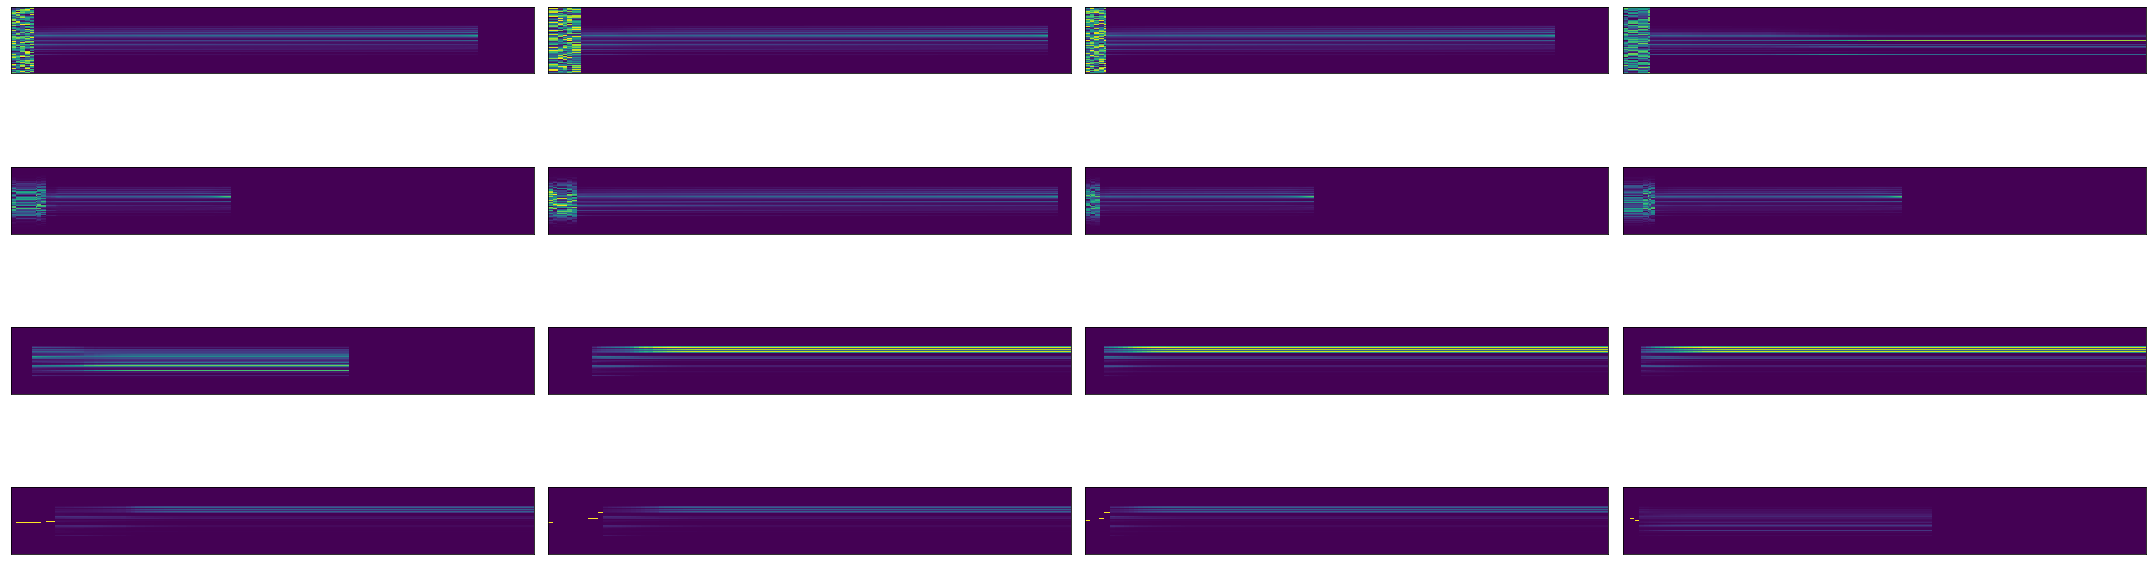

100/100 [==============================] - 9s 92ms/step - loss: 1.3683 - notes_output_loss: 0.0716 - duration_output_loss: 1.2967 - notes_output_binary_crossentropy: 0.0715 - duration_output_categorical_accuracy: 0.5562 - val_loss: 1.6061 - val_notes_output_loss: 0.0776 - val_duration_output_loss: 1.5285 - val_notes_output_binary_crossentropy: 0.0773 - val_duration_output_categorical_accuracy: 0.4590
Epoch 2/2
100/100 [==============================] - 1s 9ms/step - loss: 1.4777 - notes_output_loss: 0.0765 - duration_output_loss: 1.4011 - notes_output_binary_crossentropy: 0.0763 - duration_output_categorical_accuracy: 0.5185


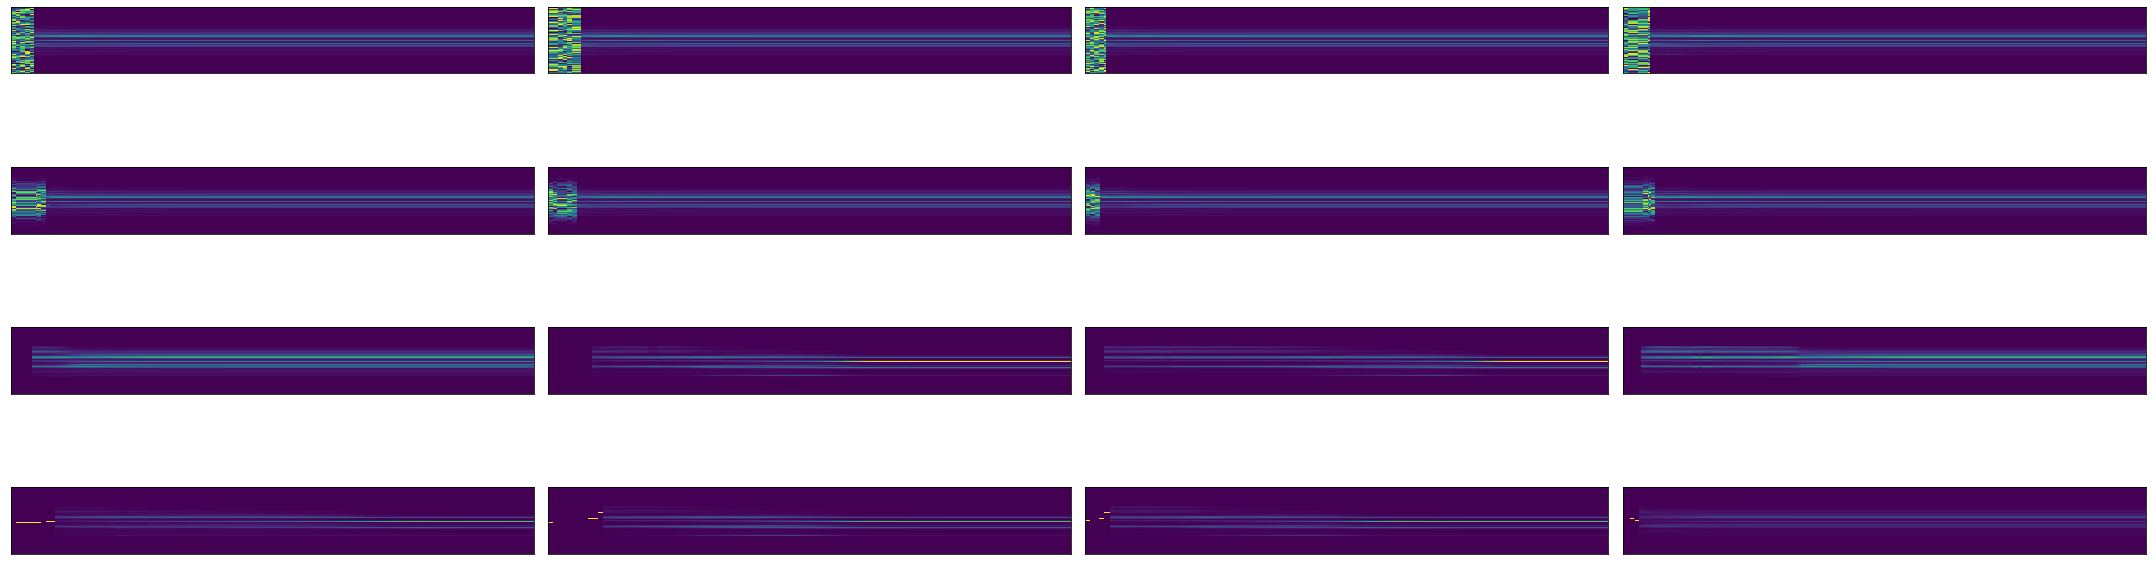

100/100 [==============================] - 8s 81ms/step - loss: 1.2070 - notes_output_loss: 0.0680 - duration_output_loss: 1.1390 - notes_output_binary_crossentropy: 0.0679 - duration_output_categorical_accuracy: 0.6134 - val_loss: 1.4777 - val_notes_output_loss: 0.0765 - val_duration_output_loss: 1.4011 - val_notes_output_binary_crossentropy: 0.0763 - val_duration_output_categorical_accuracy: 0.5185


In [21]:
EPOCHS = 2
STEPS_PER_EPOCH = 100
TEST_STEPS = 100

start_time = time()
model.fit_generator(
    data_gen,
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    validation_data=test_gen,
    validation_steps=TEST_STEPS,
    callbacks=[log_callback, gen_callback, mc_best, mc_last] if save_logs_and_models else [gen_callback] #mc, es]
)

minutes_elapsed += (time() - start_time) // 60
epochs_elapsed += EPOCHS

### convert gpu model to cpu

In [ ]:
model_path = 'lstm_clustered_time_sparse/model_best.h5'
model = K.models.load_model(os.path.join(models_base_path, model_path))

In [ ]:
from src.training.common.CUDNNLSTM_LSTM import cudnnlstm_to_lstm

cpu_model = cudnnlstm_to_lstm(model)
cpu_model.compile(
    loss='mean_squared_error',
    optimizer='adam', 
    metrics=["mean_squared_error"],
)

K.models.save_model(cpu_model, os.path.join(models_base_path, model_path).replace('.h5', '_cpu.h5'))